# Thử nghiệm 1 vài thuật toán phân cụm


'Mô tả' dữ liệu có labels trong không gian giảm chiều LDA.  

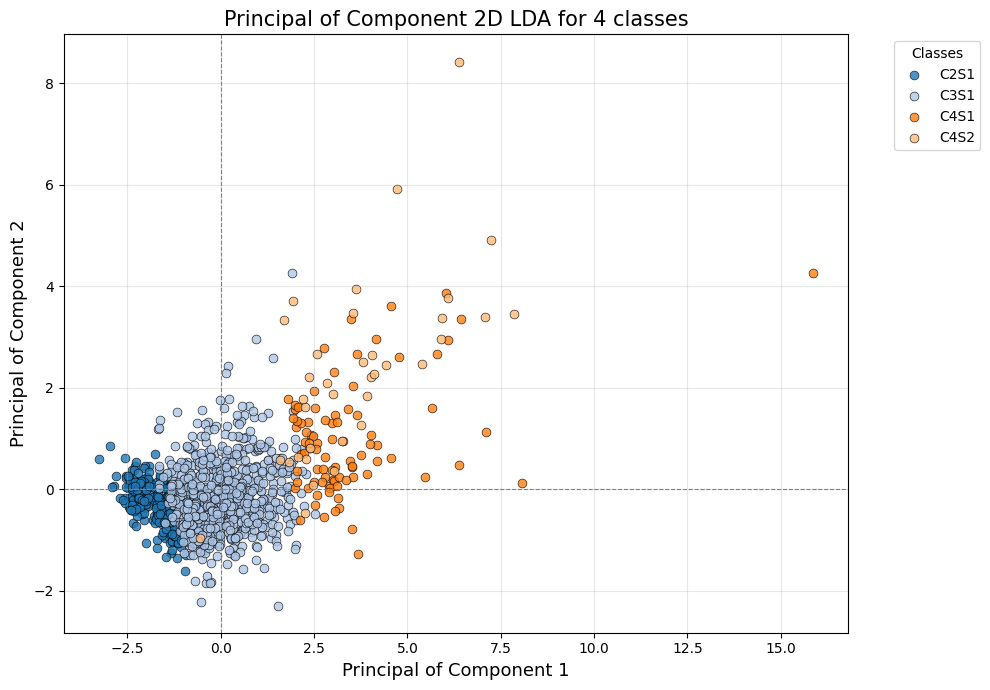

Thử nghiệm nhanh

Silhouette Score for GMM with 4 clusters: 0.36992
DBCV for GMM with 4 clusters: -0.58674
Silhouette Score for KMeans with 4 clusters: 0.39551
DBCV for KMeans with 4 clusters: -0.62671


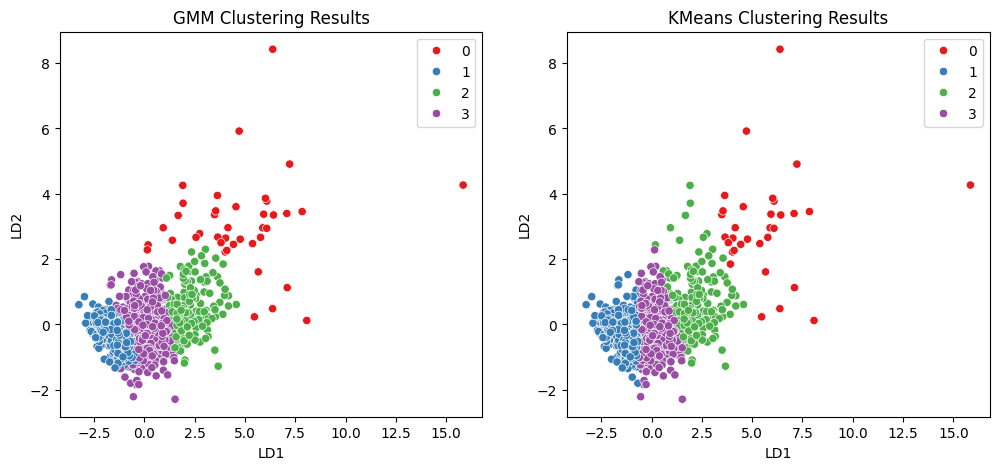

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from hdbscan.validity import validity_index
import seaborn as sns


import os
BASE_DIR = os.path.dirname(
    os.path.dirname(
        os.path.dirname(
            os.path.abspath('notebook/preprocessing.ipynb'))))

df_4 = pd.read_csv(os.path.join(BASE_DIR, 'data/X_4_classes_LDA_2dims.csv'))

X_4 = df_4.drop(columns=['Classification'])
y_4 = df_4['Classification']
y_4_encoded = y_4.factorize()[0]

gmm_4 = GaussianMixture(n_components=4, random_state=42)
gmm_4.fit(X_4)
y_4_pred_gmm = gmm_4.predict(X_4)

silhouette_gmm = silhouette_score(X_4, y_4_pred_gmm)
print(f'Silhouette Score for GMM with 4 clusters: {round(silhouette_gmm, 5)}')
dbcv_gmm = validity_index(X_4.to_numpy(), y_4_pred_gmm)
print(f'DBCV for GMM with 4 clusters: {round(dbcv_gmm, 5)}')


kmeans_4 = KMeans(n_clusters=4, random_state=42)
y_4_pred_kmeans = kmeans_4.fit_predict(X_4)

silhouette_kmeans = silhouette_score(X_4, y_4_pred_kmeans)
print(f'Silhouette Score for KMeans with 4 clusters: {round(silhouette_kmeans, 5)}')
dbcv_kmeans = validity_index(X_4.to_numpy(), y_4_pred_kmeans)
print(f'DBCV for KMeans with 4 clusters: {round(dbcv_kmeans, 5)}')

# Visualization of clustering results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_4.iloc[:, 0], y=X_4.iloc[:, 1], hue=y_4_pred_gmm, palette='Set1')
plt.title('GMM Clustering Results')
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_4.iloc[:, 0], y=X_4.iloc[:, 1], hue=y_4_pred_kmeans, palette='Set1')
plt.title('KMeans Clustering Results')
plt.show()

Thấy rằng, GMM cho ra được sự tương đối giữa kích thước của cụm tốt hơn Agglomerative so với dữ liệu gốc LDA labels.

### GMM from scratch

In [2]:
import numpy as np
from numpy import random
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import multivariate_normal

class GMM():
    def __init__(self, k, dim, init_mu=None, init_sigma=None, init_pi=None, colors=None, reg_covar=1e-6):
        '''
        Define a model with known number of clusters and dimensions.
        input:
            - k: Number of Gaussian clusters
            - dim: Dimension 
            - init_mu: initial value of mean of clusters (k, dim)
                       (default) random from uniform[-10, 10]
            - init_sigma: initial value of covariance matrix of clusters (k, dim, dim)
                          (default) Identity matrix for each cluster
            - init_pi: initial value of cluster weights (k,)
                       (default) equal value to all cluster i.e. 1/k
            - colors: Color valu for plotting each cluster (k, 3)
                      (default) random from uniform[0, 1]
            - reg_covar: Regularization added to the diagonal of covariance matrices
                         to prevent singular matrices (default: 1e-6)
        '''
        self.k = k
        self.dim = dim
        self.reg_covar = reg_covar
        if(init_mu is None):
            init_mu = random.rand(k, dim)*20 - 10
        self.mu = init_mu
        if(init_sigma is None):
            init_sigma = np.zeros((k, dim, dim))
            for i in range(k):
                init_sigma[i] = np.eye(dim)
        self.sigma = init_sigma
        if(init_pi is None):
            init_pi = np.ones(self.k)/self.k
        self.pi = init_pi
        if(colors is None):
            colors = random.rand(k, 3)
            for i in range(k):
                colors[i, 2] = i/k
        self.colors = colors
    
    def init_em(self, X):
        '''
        Initialization for EM algorithm.
        input:
            - X: data (batch_size, dim)
        '''
        self.data = X
        self.num_points = X.shape[0]
        self.z = np.zeros((self.num_points, self.k))
    
    def e_step(self):
        '''
        E-step of EM algorithm.
        '''
        for i in range(self.k):
            self.z[:, i] = self.pi[i] * multivariate_normal.pdf(self.data, mean=self.mu[i], cov=self.sigma[i])
        self.z /= self.z.sum(axis=1, keepdims=True)
    
    def m_step(self):
        '''
        M-step of EM algorithm.
        '''
        sum_z = self.z.sum(axis=0)
        self.pi = sum_z / self.num_points
        self.mu = np.matmul(self.z.T, self.data)
        self.mu /= sum_z[:, None]
        for i in range(self.k):
            j = np.expand_dims(self.data, axis=1) - self.mu[i]
            s = np.matmul(j.transpose([0, 2, 1]), j)
            self.sigma[i] = np.matmul(s.transpose(1, 2, 0), self.z[:, i] )
            self.sigma[i] /= sum_z[i]
            # Add regularization to prevent singular covariance matrices
            self.sigma[i] += self.reg_covar * np.eye(self.dim)
            
    def log_likelihood(self, X):
        '''
        Compute the log-likelihood of X under current parameters
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of X: Sum_n Sum_k log(pi_k * N( X_n | mu_k, sigma_k ))
        '''
        ll = []
        for d in X:
            tot = 0
            for i in range(self.k):
                tot += self.pi[i] * multivariate_normal.pdf(d, mean=self.mu[i], cov=self.sigma[i])
            ll.append(np.log(tot))
        return np.sum(ll)
    
    def plot_gaussian(self, mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
        '''
        Utility function to plot one Gaussian from mean and covariance.
        '''
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x = mean[0]
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y = mean[1]
        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)
        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)

    def draw(self, ax, n_std=2.0, facecolor='none', **kwargs):
        '''
        Function to draw the Gaussians.
        Note: Only for two-dimensionl dataset
        '''
        if(self.dim != 2):
            print("Drawing available only for 2D case.")
            return
        for i in range(self.k):
            self.plot_gaussian(self.mu[i], self.sigma[i], ax, n_std=n_std, edgecolor=self.colors[i], **kwargs)

In [3]:
def plot(title, gmm, X_4_np):
    '''
    Draw the data points and the fitted mixture model.
    input:
        - title: title of plot and name with which it will be saved.
    '''
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    ax.scatter(X_4_np[:, 0], X_4_np[:, 1], s=3, alpha=0.4)
    ax.scatter(gmm.mu[:, 0], gmm.mu[:, 1], c=gmm.colors)
    gmm.draw(ax, lw=3)
    ax.set_xlim((-22, 22))
    ax.set_ylim((-22, 22))
    
    plt.title(title)
    plt.show()
    plt.clf()

Initial centroids from K-Means:
[[ 5.67235737  2.99891021]
 [-1.48574361 -0.24208593]
 [ 2.16566351  0.66695414]
 [ 0.14609371 -0.24809972]]


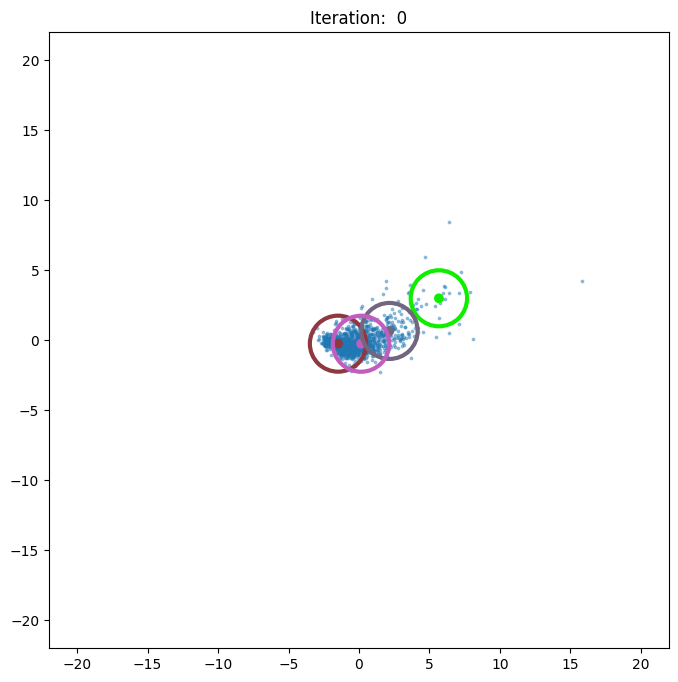

Iteration: 1, log-likelihood: -3034.5840
Iteration: 2, log-likelihood: -3014.7830
Iteration: 3, log-likelihood: -3003.7878
Iteration: 4, log-likelihood: -2996.7238
Iteration: 5, log-likelihood: -2992.5038
Iteration: 6, log-likelihood: -2990.0575
Iteration: 7, log-likelihood: -2988.5646
Iteration: 8, log-likelihood: -2987.5822
Iteration: 9, log-likelihood: -2986.8917
Iteration: 10, log-likelihood: -2986.3801
Iteration: 11, log-likelihood: -2985.9846
Iteration: 12, log-likelihood: -2985.6681
Iteration: 13, log-likelihood: -2985.4079
Iteration: 14, log-likelihood: -2985.1897
Iteration: 15, log-likelihood: -2985.0038
Iteration: 16, log-likelihood: -2984.8439
Iteration: 17, log-likelihood: -2984.7052
Iteration: 18, log-likelihood: -2984.5842
Iteration: 19, log-likelihood: -2984.4782
Iteration: 20, log-likelihood: -2984.3852


<Figure size 640x480 with 0 Axes>

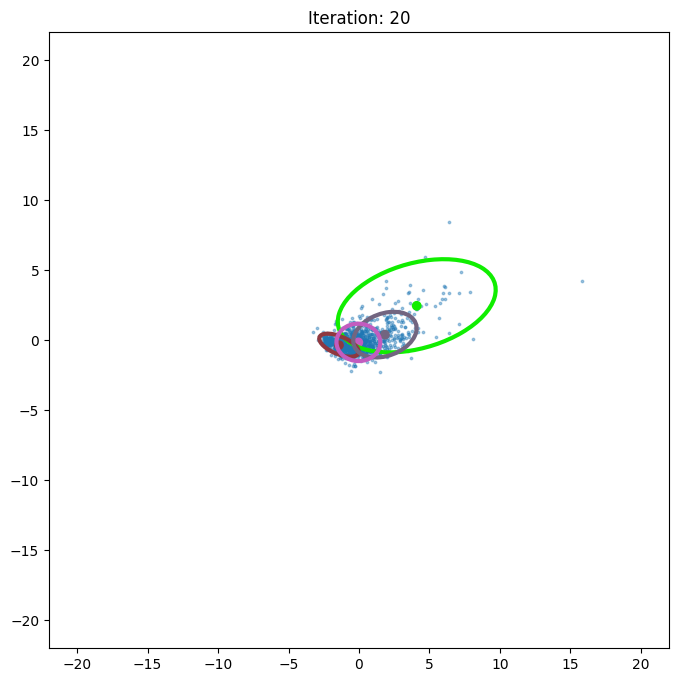

<Figure size 640x480 with 0 Axes>

In [4]:
from sklearn.cluster import KMeans

X_4_np = X_4.to_numpy()

# Run K-Means for 10 iterations to get good initial centroids
kmeans = KMeans(n_clusters=4, max_iter=10, n_init=1, random_state=42)
kmeans.fit(X_4_np)
initial_centroids = kmeans.cluster_centers_

print("Initial centroids from K-Means:")
print(initial_centroids)

# Initialize GMM with K-Means centroids
gmm = GMM(k=4, dim=2, init_mu=initial_centroids)
gmm.init_em(X_4_np)

num_iters = 20

log_likelihood = [gmm.log_likelihood(X_4_np)]
# plotting
plot("Iteration:  0", gmm, X_4_np)
for e in range(num_iters):
    # E-step
    gmm.e_step()
    # M-step
    gmm.m_step()
    # Computing log-likelihood
    log_likelihood.append(gmm.log_likelihood(X_4_np))
    print("Iteration: {}, log-likelihood: {:.4f}".format(e+1, log_likelihood[-1]))
# plotting
plot(title="Iteration: " + str(e+1), gmm=gmm, X_4_np=X_4_np)

In [5]:
# Display probability matrix - each row is a data point, each column is probability for a cluster
probabilities = gmm.z

print(f"Probability matrix shape: {probabilities.shape}")
print(f"Each row sums to 1.0: {np.allclose(probabilities.sum(axis=1), 1.0)}")
print("\nFirst 10 data points - probabilities of belonging to each cluster:")
print(probabilities[:10])

# Create a DataFrame for better visualization
prob_df = pd.DataFrame(
    probabilities, 
    columns=[f'Cluster_{i+1}_Prob' for i in range(4)]
)
prob_df['Most_Likely_Cluster'] = prob_df.values.argmax(axis=1) + 1
print("\nProbability DataFrame (first 10 rows):")
print(prob_df.head(10))

Probability matrix shape: (1067, 4)
Each row sums to 1.0: True

First 10 data points - probabilities of belonging to each cluster:
[[1.07392080e-03 8.27636084e-01 2.81012418e-03 1.68479871e-01]
 [2.26621011e-03 3.19065941e-01 1.52806923e-02 6.63387157e-01]
 [5.11678590e-04 9.31398739e-01 1.15376303e-03 6.69358189e-02]
 [7.47517262e-04 9.73918837e-01 4.43465642e-04 2.48901799e-02]
 [1.16284503e-01 5.34524188e-25 8.79479013e-01 4.23648418e-03]
 [2.35435204e-03 1.64593435e-01 2.25285965e-02 8.10523616e-01]
 [3.97626803e-02 1.34049937e-16 9.20053291e-01 4.01840289e-02]
 [2.20983914e-03 2.39256844e-01 1.89706875e-02 7.39562630e-01]
 [3.54452723e-01 2.73728605e-33 6.45044338e-01 5.02939929e-04]
 [2.27545192e-03 9.91103265e-01 1.40422991e-04 6.48085994e-03]]

Probability DataFrame (first 10 rows):
   Cluster_1_Prob  Cluster_2_Prob  Cluster_3_Prob  Cluster_4_Prob  \
0        0.001074    8.276361e-01        0.002810        0.168480   
1        0.002266    3.190659e-01        0.015281        0.6

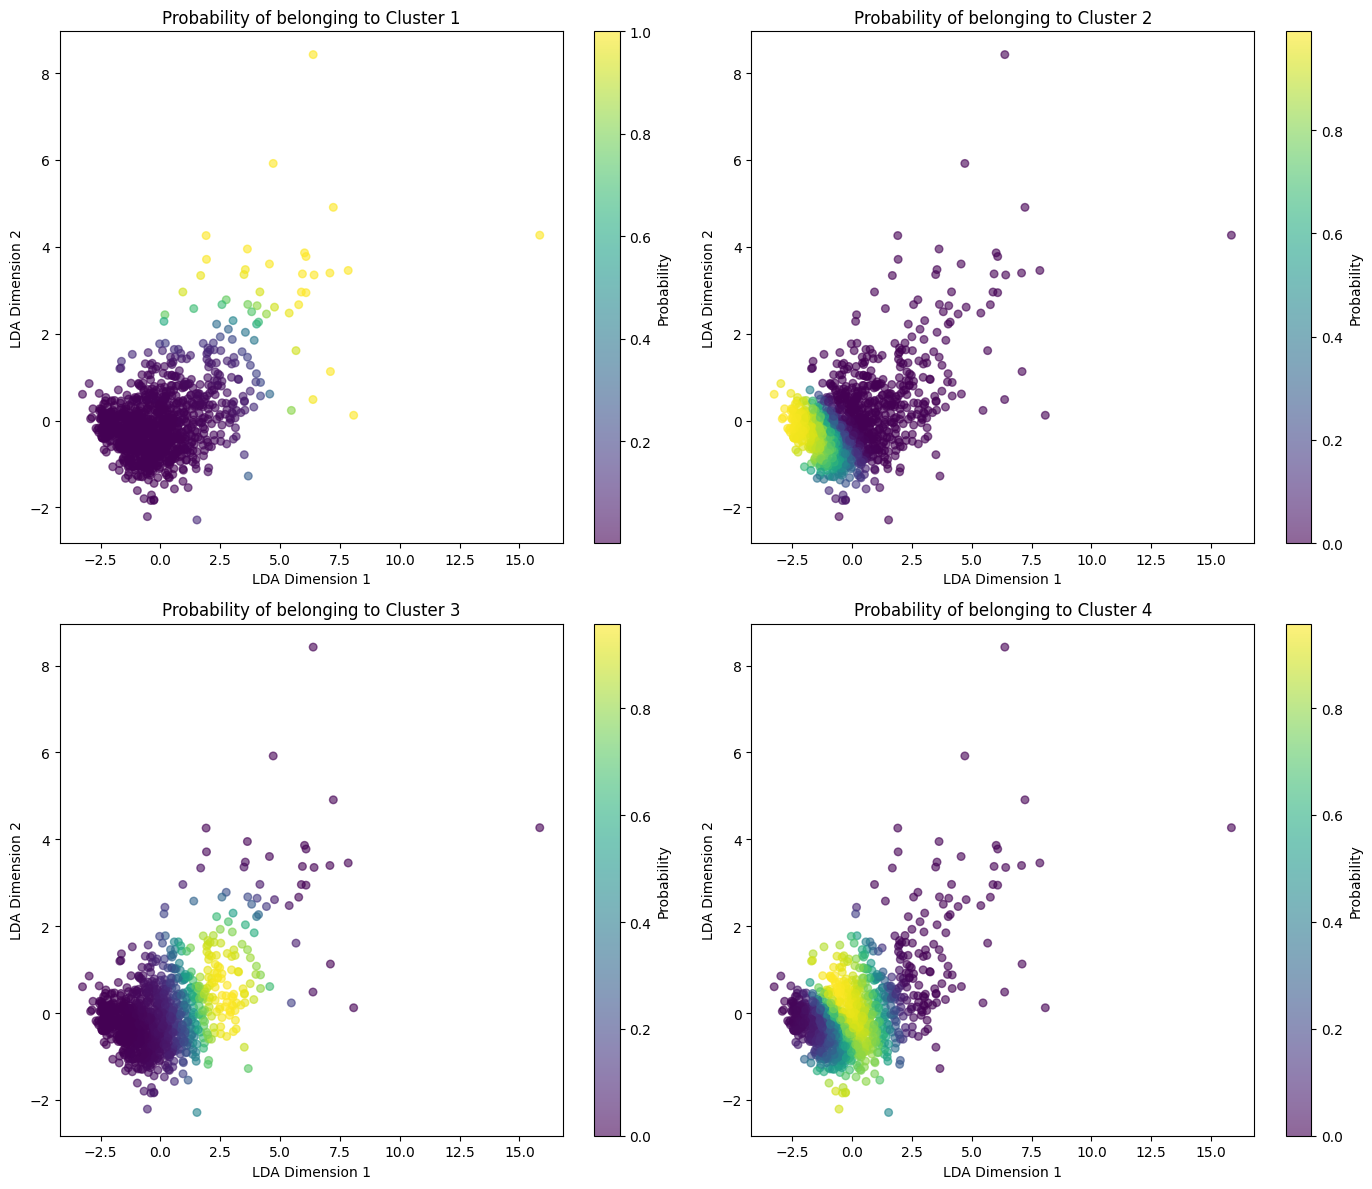

In [6]:
# Visualize probability distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for i in range(4):
    ax = axes[i // 2, i % 2]
    scatter = ax.scatter(X_4_np[:, 0], X_4_np[:, 1], 
                        c=probabilities[:, i], 
                        cmap='viridis', 
                        s=30, 
                        alpha=0.6)
    ax.set_title(f'Probability of belonging to Cluster {i+1}')
    ax.set_xlabel('LDA Dimension 1')
    ax.set_ylabel('LDA Dimension 2')
    plt.colorbar(scatter, ax=ax, label='Probability')

plt.tight_layout()
plt.show()

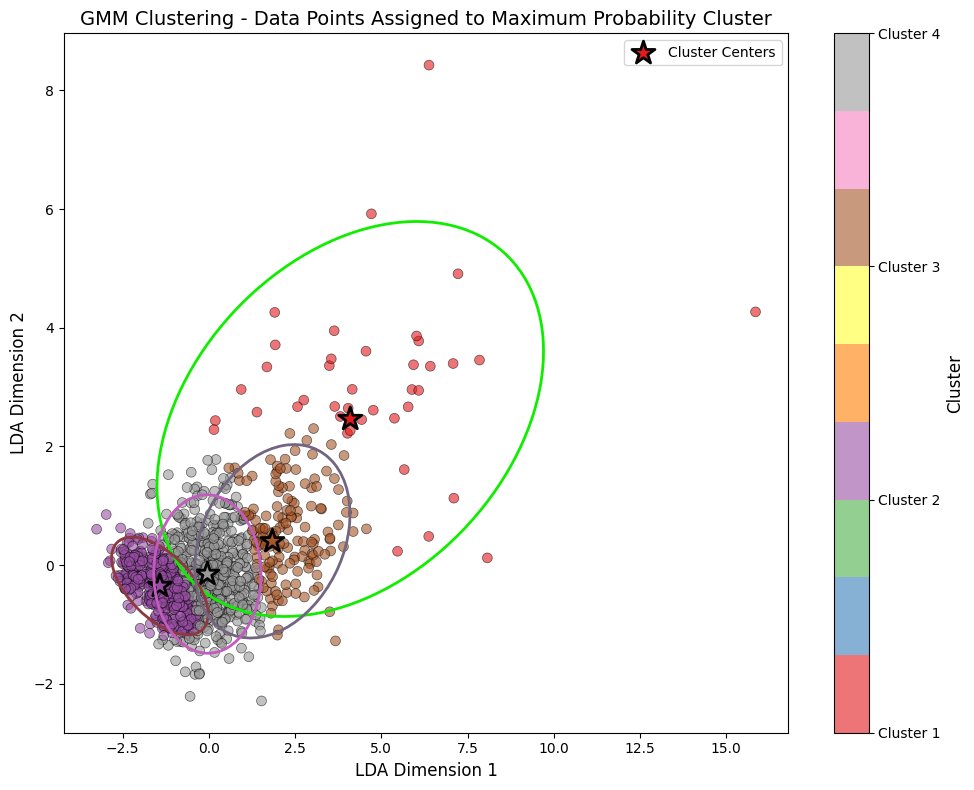


Cluster distribution:
Cluster 1: 40 points (3.75%)
Cluster 2: 390 points (36.55%)
Cluster 3: 154 points (14.43%)
Cluster 4: 483 points (45.27%)


In [7]:
# Assign each data point to cluster with maximum probability
cluster_assignments = np.argmax(probabilities, axis=1)

# Plot all data points colored by their assigned cluster
fig, ax = plt.subplots(figsize=(10, 8))

# Create scatter plot with different colors for each cluster
scatter = ax.scatter(X_4_np[:, 0], X_4_np[:, 1], 
                    c=cluster_assignments, 
                    cmap='Set1', 
                    s=50, 
                    alpha=0.6,
                    edgecolors='black',
                    linewidth=0.5)

# Add cluster centers
ax.scatter(gmm.mu[:, 0], gmm.mu[:, 1], 
          c=range(4), 
          cmap='Set1',
          s=300, 
          marker='*',
          edgecolors='black',
          linewidth=2,
          label='Cluster Centers')

# Draw Gaussian ellipses
gmm.draw(ax, n_std=2.0, lw=2)

ax.set_xlabel('LDA Dimension 1', fontsize=12)
ax.set_ylabel('LDA Dimension 2', fontsize=12)
ax.set_title('GMM Clustering - Data Points Assigned to Maximum Probability Cluster', fontsize=14)
ax.legend()

# Add colorbar to show cluster mapping
cbar = plt.colorbar(scatter, ax=ax, ticks=[0, 1, 2, 3])
cbar.set_label('Cluster', fontsize=12)
cbar.ax.set_yticklabels(['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])

plt.tight_layout()
plt.show()

# Print cluster distribution
unique, counts = np.unique(cluster_assignments, return_counts=True)
print("\nCluster distribution:")
for cluster, count in zip(unique, counts):
    print(f"Cluster {cluster + 1}: {count} points ({count/len(cluster_assignments)*100:.2f}%)")